# More loss functions & change-of-basis

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [6]:
using Distributions
using Plots
using Plots.PlotMeasures
using Printf
#= run once
using Pkg
Pkg.add("Optim")
Pkg.add("ScikitLearn")
Pkg.add("Combinatorics") =#
using Optim
using ScikitLearn
using Combinatorics
using Random
include("__init__.jl")

 Resolving package versions...
 Installed Polynomials ─── v0.5.2
 Installed Combinatorics ─ v0.7.0
  Updating `C:\Users\jasonsyc.STUDENTS.000\.julia\environments\v0.7\Project.toml`
  [861a8166] + Combinatorics v0.7.0
  Updating `C:\Users\jasonsyc.STUDENTS.000\.julia\environments\v0.7\Manifest.toml`
  [861a8166] + Combinatorics v0.7.0
  [f27b6e38] + Polynomials v0.5.2


┌ Info: Precompiling Combinatorics [861a8166-3701-5b0c-9a16-15d98fcdc6aa]
└ @ Base loading.jl:1187


## Admin

- Monday is a holiday (no class).
- If you don't like Jupyter lectures, don't worry - we'll be switching back on Wednesday.
- a3 released, due in a week from today.
- List of midterm topics will be posted soon.
- End of today: a3 material covered.
- IMHO last class and today are two of the most important lectures in CPSC 340 (no pressure!).

In [10]:
function gen_outlier_data(;n=40,Noutliers=3)
    # generate random data
    x = rand(Normal(),n)
    y = 3 .* x
    # add random outliers
    y[1:Noutliers] = -3 .* (x[1:Noutliers]+rand(Normal(),Noutliers) .* 0.1)

    X = reshape(x,n,1) # reshape for sklearn

    return (X,y)
end

gen_outlier_data (generic function with 1 method)

## Smooth approximations and the Huber loss

- The absolute value (L1) loss, $ f(w) = \sum_{i=1}^n\left|w^T x_i-y_i\right| $ is **non-smooth**. 
- Gradient descent not guaranteed to converge with constant $\alpha$. 
- One solution: use a **smooth approximation** to the loss. 
- For example, we can minimize the **Huber** objective

$$ \sum_{i=1}^n h \left( y_i-w^\top x_i\right) $$

where $$h(z) \equiv \begin{cases} 
      \frac{1}{2} z^2 & \textrm{if} \; |z|\leq 1 \\   |z|-\frac12 & \textrm{if} \; |z|>1
   \end{cases} $$

with gradient descent. This will hopefully give us robust regression because big distances aren't amplified in the objective.



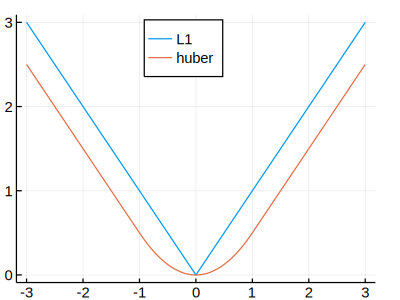

In [14]:
huber(z) = broadcast(x->(abs(x)<=1.0) ? 0.5*x^2 : abs(x)-0.5,z)

grid = -3:0.006:3
plot(grid, broadcast(abs,grid),
    label="L1",
    size=(1600,1200),
    thickness_scaling=5,
    left_margin=-40px,
    bottom_margin=-45px,
    legend=:top
)
plot!(grid, huber(grid), label="huber")

(BONUS "SLIDE")

For linear regression in one dimension the Huber objective becomes

$$f(w,\beta)=\displaystyle \sum_{i=1}^n h\left(w x_i + \beta - y_i\right) $$

The gradient is

$$\frac{\partial f}{\partial w} = \sum_{i=1}^n  x_i h'\left( w x_i +\beta - y_i\right)$$ 

$$\frac{\partial f}{\partial \beta} = \sum_{i=1}^n  h'\left(w x_i +\beta - y_i\right)$$ 

where $$h'(z) = \begin{cases} 
       z & \textrm{if} \; |z|\leq 1 \\   \textrm{sign}(z) & \textrm{if} \; |z|>1
   \end{cases} $$
   
Minimizing this objective yields the robust fit, and in general is a very sensible thing to do!

w = 2.937486
b = -0.090881


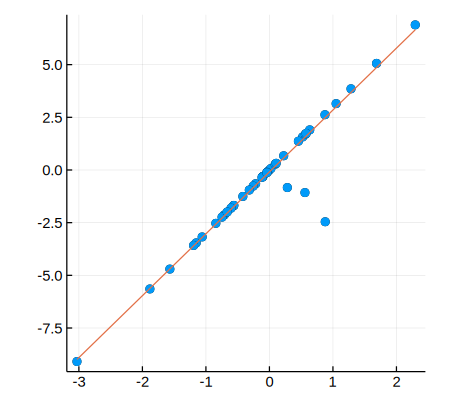

In [41]:
(X,y) = gen_outlier_data()
x=X[:]

w = 0.0
β = 0.0
α = 0.01

Nsteps = 1000
yhat(x,w,b) = w .* x .+ b

huber_deriv(z) = broadcast(x->(abs(x)<=1) ? x : sign(x),z)

for t in 0:Nsteps-1
    dLdw = -sum(x.*huber_deriv(y .-yhat(x,w,β)))
    dLdβ = -sum(huber_deriv(y .-yhat(x,w,β)))
    w -= α*dLdw
    β -= α*dLdβ
end
    
Printf.@printf("w = %f\n", w)
Printf.@printf("b = %f\n", β)

plot(x,y,
    seriestype=:scatter,
    markersize=20,
    size=(1800,1600),
    thickness_scaling=5,
    left_margin=-85px,
    bottom_margin=-45px,
    legend=false
)
plot!(x,w .*x .+β)

## Log-sum-exp approximation 

- The log-sum-exp approximiation is a mathematical approximation, totally apart from machine learning:

$$\displaystyle \max_i\{z_i\} \approx \log \left(\sum_i \exp(z_i)\right)$$

- We will use this several times in the course, including in a3
- The intuition is that the largest element is magnified exponentially, so we can roughly neglect the rest
  - This reduces it to $\log \left(\sum_i \exp(z_i)\right) \approx \log\left(\exp(\max_i\{z_i\})\right)=\max_i\{z_i\}$

In [42]:
nums = [2,20,5,-100,7]
log(sum(broadcast(exp,nums))) # this is a good approximation

20.000002581458375

In [43]:
nums = [2,20,19.99,-100,7]
log(sum(broadcast(exp,nums))) # here it's less good because the runner-up is close

20.688160823975753

One use of log-sum-exp:

- One can rewrite $|z|$ as $\max\{z,-z\}$ (more on this below).
- You can then apply log-sum-exp to this max, and get a smooth approximation of $z$.
- This is an alternative to the Huber loss, and appears on a3. 

Another use of log-sum-exp: brittle regression.

## Brittle regression

- Brittle regression is the opposite of robust regression: we want to minimize the maximum distance to a point.
- A possible loss function is $f(w)=\|Xw-y\|_\infty$ where $\|z\|_\infty\equiv \max_i\{|z_i|\}$. 
- Applying log-sum-exp to the max yields $f(w)=\log \sum_{i=1}^n \exp \left( |w^Tx_i - y_i | \right)$



Confusion warning:

- Robust regression and brittle regression are the opposite of each other
- But both losses are non-smooth
- The log-sum-exp approximation can help in both cases, since both can be written in terms of a max

### Digression: overloading the definition of "max" (or "min") 


| In words  |  In math notation  |  Output type  |  In Python |
|-----------|-----------|---------------|------------|
| maximizing a function over its domain | $\max_x f(x)$ | same type as $x$ (a number, a vector, ...) | `scipy.optimize.minimize` |
| selecting the largest element from a set | $\max(\{a,b\})$ | a number | `np.max` |
| a function given by the max of two other functions | $\max(f(x),g(x))$ | a **function** | `np.maximum` | 

Case (3) seems to confuse a lot of students. Here are some examples...

#### Case 1

$\displaystyle \min_x \, (x-5)^2+3$

In [52]:
func(x) = (sum(x)-5)^2+3
x0 = zeros(1)
result = optimize(func, x0, Newton())
Printf.@printf("min = %f\n", Optim.minimum(result))
Printf.@printf("arg min = %f\n", Optim.minimizer(result)[1])

min = 3.000000
arg min = 5.000000


#### Case 2

$\max \left( \{9, -34, 100, 7\} \right)$

In [53]:
x = [9,-34,100,7]
println(maximum(x))
println(argmax(x))

100
3


#### Case 3

$f(x)=\max(x^2, \sqrt{x})$

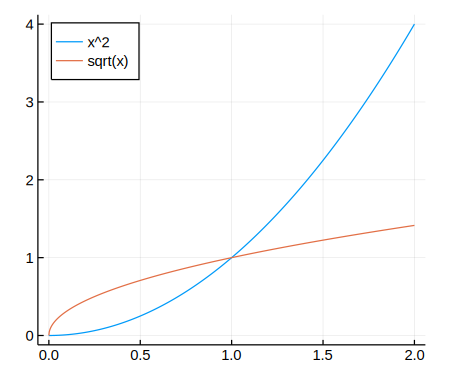

In [7]:
x = 0:0.002:2
f(z) = z.^2
g(z) = broadcast(sqrt,z)
plot(x,f(x),
    label="x^2",
    size=(1800,1500),
    thickness_scaling=5,
    legend=:topleft
)
plot!(x,g(x), label="sqrt(x)")

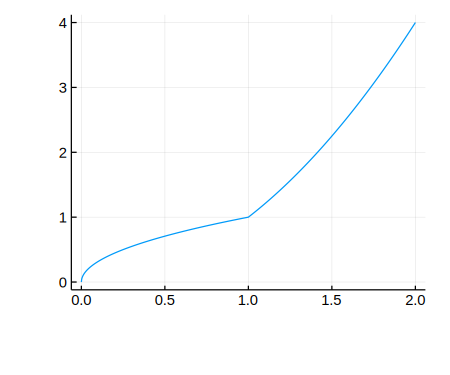

In [63]:
plot(x, [max(f(y),g(y)) for y in x],
    size=(1800,1500),
    thickness_scaling=5,
    legend=false
)

Observe!

- We saw this type of picture in the slides about convex functions.
- Look at the corner! It's located where the functions "switch"
- Let's try smoothing this function with log-sum-exp!

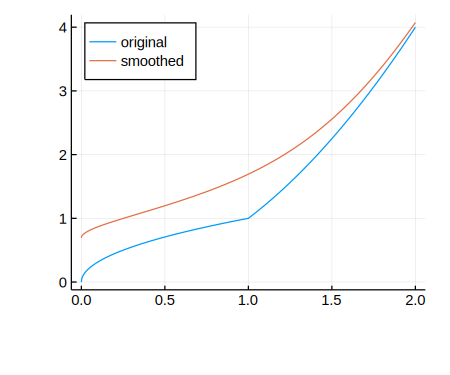

In [8]:
plot(x, [max(f(y),g(y)) for y in x], 
    label="original",
    size=(1800,1500),
    thickness_scaling=5,
    legend=:topleft
)
plot!(x, broadcast(y->log(exp(f(y))+exp(g(y))),x),
    label="smoothed")

Earlier we said $|x|$ is the same as $\max(x, -x)$. Let's test it out:

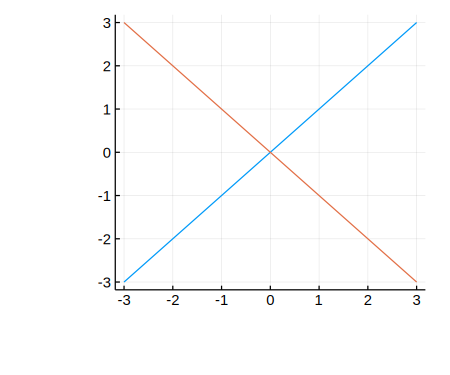

In [71]:
x = range(-3,stop=3,length=1000)
f(z) = z
g(z) = -z
plot(x,f(x),
    size=(1800,1500),
    thickness_scaling=5,
    legend=false
)
plot!(x,broadcast(g,x))

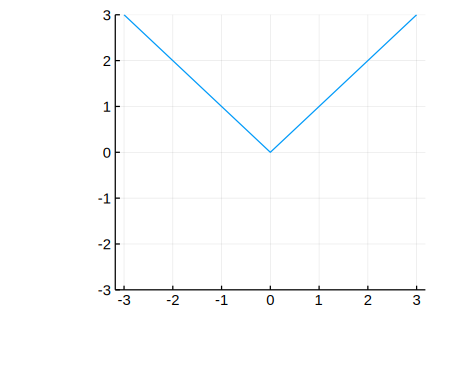

In [74]:
plot(x, [max(a,b) for (a,b) in zip(f(x),g(x))],
    size=(1800,1500),
    thickness_scaling=5,
    legend=false,
    ylims=(-3,3)
)

We can also plot the log-sum-exp approximation of this function:

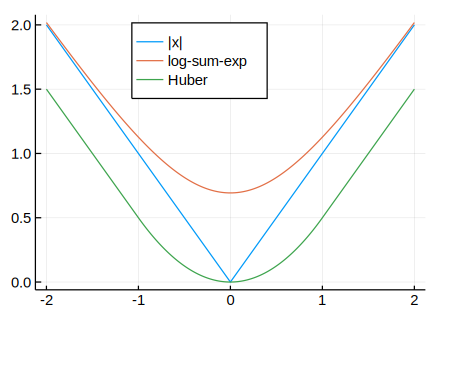

In [82]:
x = -2:0.004:2
plot(x, broadcast(abs,x),
    label="|x|",
    size=(1800,1500),
    thickness_scaling=5,
    legend=:top,
    left_margin=-75px
)
plot!(x, broadcast(log,broadcast(exp,x)+broadcast(exp,-x)),
    label="log-sum-exp");
plot!(x, huber(x), label="Huber")

Both look reasonable.

## Summary of loss functions we've covered

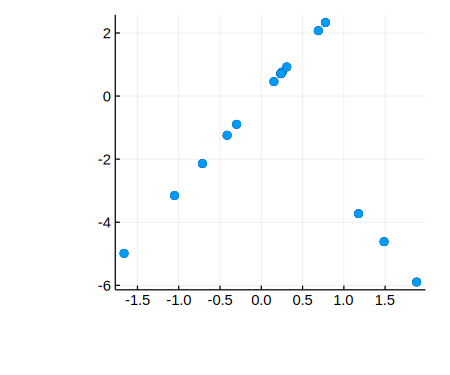

In [11]:
Random.seed!(53)
# the demo is set up for this case 

n = 15
(X, y) = gen_outlier_data(n=n,Noutliers=3)
x = X[:]

# add column of 1's to X
X = hcat(X, ones(n))

# plot the points
plot(x,y,
    seriestype=:scatter,
    thickness_scaling=5,
    size=(1800,1500),
    legend=false,
    markersize=20
)

In [118]:
# NO NEED TO READ THIS CODE

function plot_loss(loss_fun, X, y, w; wmin=-5.0, wmax=5.0, bmin=-5.0, bmax=5.0)
    m = 300
    w_lin = range(wmin, stop=wmax, length=m)
    b_lin = range(bmin, stop=bmax, length=m)
    
    pred = w_lin*X[:,1]' .+ b_lin

    loss = [sum(loss_fun(pred[i,:]-y)) for i in 1:m]
    plotLoss = false
    if maximum(loss) > 1e5
        print("Plotting log")
        loss = broadcast(log,loss)
        plotLoss = true
    end
    p = contour(w_lin, b_lin,
        (w,b)-> plotLoss ? log(sum(loss_fun(w.*X[:,1].+b-y))) : sum(loss_fun(w.*X[:,1].+b-y)),
        nlevels=10, w=4, fill=true)
    imin = argmin(loss)
    plot!([w_lin[imin]], [b_lin[imin]],
        seriestype=:scatter,
        markersize=20,
        xlabel="w",
        ylabel="beta",
        title="Loss in w-beta space",
        legend=false
    )
    plot!([w[1]],[w[2]],
        seriestype=:scatter,
        markersize=20,
        title="Loss contours in parameter space"
    )
    return p
end

function make_plots(error_fun; verbose=false, w0=undef)
    loss_fun(w) = sum(error_fun(X*w-y))
    grid = -5:0.01:5
    p1 = plot(grid, error_fun(grid),
        title="The loss on each residual",
        xlabel="r_i",
        ylabel="f_i(r_i)",
        legend=false
    )
    if w0==undef
        w0 = rand(Normal(),2)
    end
    ret = optimize(loss_fun, w0)
    w = Optim.minimizer(ret)
    p2 = plot_loss(error_fun,X,y,w)
    if verbose
        println(ret)
    end
    p3 = plot(x,y,
        seriestype=:scatter,
        markersize=20,
        title="Fit model in data space",
        xlabel="x",
        ylabel="y",
        legend=false
    )
    plot!(x,X*w)
    display(plot(p1,p2,p3,
        size=(2400,1500),
        thickness_scaling=5,
        titlefontsize=10,
        left_margin=-70px,
        bottom_margin=-45px
    ))
    return w
end

make_plots (generic function with 1 method)

The **squared loss**:

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2 = ||Xw-y||^2_2$$

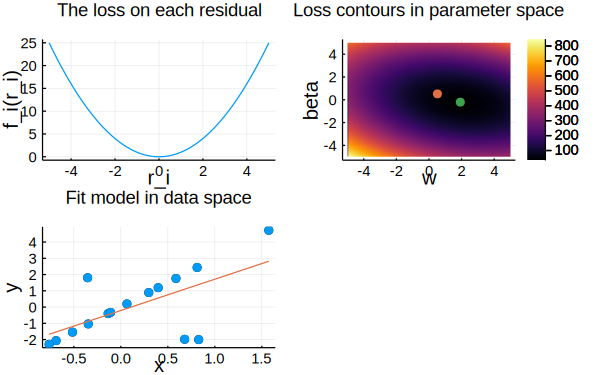

In [9]:
make_plots(x->x.^2);

The **absolute value loss**:

$$f(w)=\sum_{i=1}^n \left|w^Tx_i-y_i\right| = \| Xw-y \|_1$$

Or the **Huber loss**.

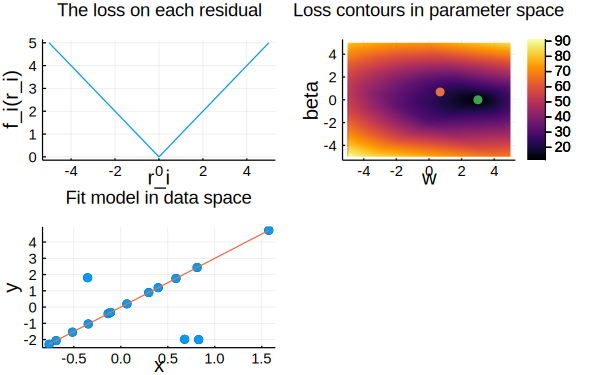

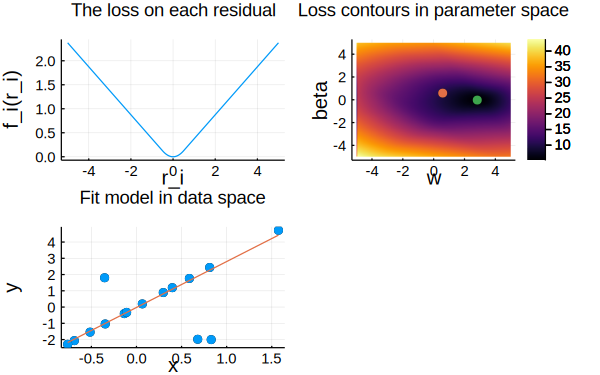

In [12]:
make_plots(x->broadcast(abs,x));
huber(x,delta) = abs(x)<=delta ? 0.5*x^2 : delta*(abs(x)-0.5*delta)
make_plots(x->broadcast(y->huber(y,0.5),x)); # try playing with the "delta" parameter

(THE NEXT FEW "SLIDES", ON THE SUPER-ROBUST LOSS, ARE BONUS) 

A non-convex **"super-robust" loss**:

$$f(w)=\sum_{i=1}^n \left|w^Tx_i-y_i\right|^{1/2}$$

There are two problems here: 

1. non-smoothness
2. non-convexity 

Unlike the above cases, re-running the code yields different results because of the random initialization of the optimization procedure.

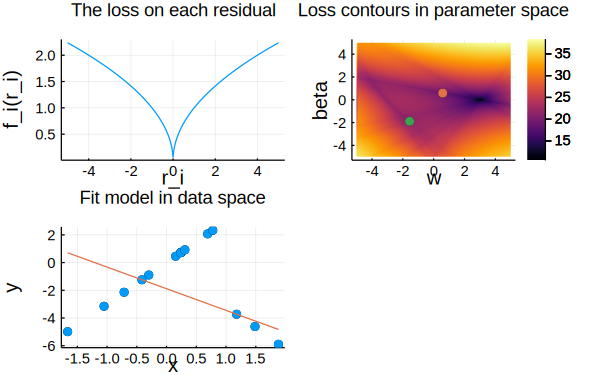

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-1.0155341393213855,-1.729783713888502]
 * Minimizer: [-1.5617279315849535,-1.889947167343296]
 * Minimum: 2.084745e+01
 * Iterations: 130
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 254


2-element Array{Float64,1}:
 -1.5617279315849535
 -1.889947167343296 

In [106]:
L12(z) = sqrt(abs(z))
w = make_plots(x->broadcast(L12,x), verbose=true)

This is clearly not minimizing the loss. Let's zoom in...

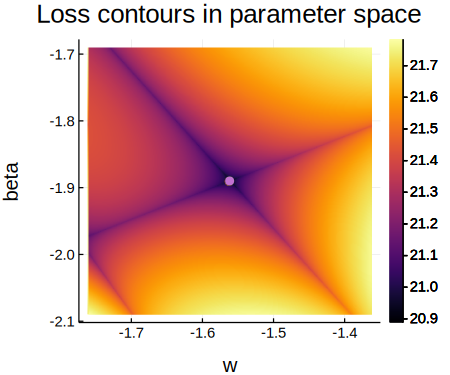

In [126]:
plot_loss(x->broadcast(L12,x), X, y, w, wmin=w[1]-.2, wmax=w[1]+.2, bmin=w[2]-.2, bmax=w[2]+.2)
plot!([w[1]],[w[2]],
    seriestype=:scatter,
    markersize=20,
    size=(1800,1500),
    thickness_scaling=5
)

We can evaluate the gradient at this $w$ to see if it is zero:

In [131]:
f(w) = sum(broadcast(x->sqrt(abs(x)),X*w-y))
[sum(X[:,i] .* w[i] ./ (2 .* broadcast(x->sqrt(abs(x)),X*w-y))) for i in 1:2]
# approx_fprime(w, f, 1e-6) # too lazy to take gradient by hand, using numerical differentiation

2-element Array{Float64,1}:
 -4.637406383307096e6
 -2.49742944264555e7 

We have to be very careful about blindly applying optimization algorithms to functions that don't satisfy the assumptions of the optimizer.

We can also do a smooth approximation of the super-robust loss. It is smooth but non-convex. Though in this particular case there don't seem to be any local minima. You can fiddle with it and get local minima though.

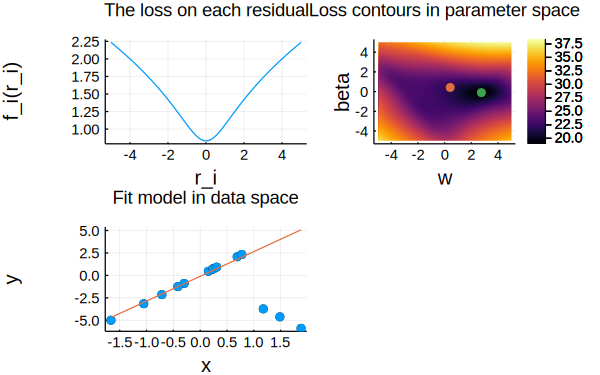

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-0.2945327048968443,-0.10238334340541137, ...]
 * Minimizer: [2.753625449183283,-0.10350171056864334]
 * Minimum: 1.898039e+01
 * Iterations: 40
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 81


2-element Array{Float64,1}:
  2.753625449183283  
 -0.10350171056864334

In [132]:
L12_smooth(z) = broadcast(x->sqrt(log(exp(x)+exp(-x))),z)
w = make_plots(L12_smooth, verbose=true)

The **brittle loss**:

$$f(w)=\max_{i=1,\ldots,n} \left|w^Tx_i-y_i\right| = \|Xw-y\|_{\infty}$$

Or its smooth approximation:

$$f(w)=\log \sum_{i=1}^n \exp\left(w^Tx_i-y_i\right)$$

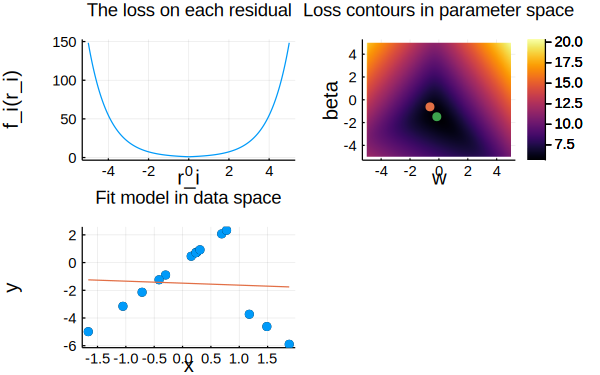

Plotting log

2-element Array{Float64,1}:
 -0.14404333923801058
 -1.4855277733637866 

In [133]:
L_inf(z) = broadcast(x->exp(abs(x)),z)
w = make_plots(L_inf)
# print(L_inf(X*w-y))

Notice the shape of the level sets. It says that if we increase the slope $w$ and decrease the intercept $\beta$, the loss doesn't change much. This is because by increasing the slope and decreasing the intercept the right amount, we keep our prediction roughly the same around $x=2$. In fact, these are only the predictions the loss cares about, since that's where the biggest residuals occur.

-----------


## Non-linear regression

- On many datasets, $y$ is not a linear function of $x$
- Can we use "linear regression" to fit **non-linear** models?
- Yes. You can do this by **changing the features**:

$$ X= \begin{bmatrix} 0.2 \\ -0.5 \\ 1 \\ 4 \end{bmatrix} \quad Z= \begin{bmatrix} 1 & 0.2 & (0.2)^2 \\ 1 & -0.5 & (-0.5)^2 \\ 1 & 1 & (1)^2 \\ 1 & 4 & (4)^2 \end{bmatrix} $$

Then prediction is $$y = v_1z_1 + v_2z_2 + v_3z_3$$

or, equivalently,

$$y = w_0 + w_1 x + w_2 x^2$$

(Reminder: when dealing with $X$ transformed to $Z$, we'll call the parameters $v$ instead of $w$.)

Big ideas here:

- You can fit a non-linear model "using linear regression"!!
- Still have access to the normal equations, all that good stuff.
- The "linear" in linear regression has two meanings:
  - The model is linear in $x$ (data view, no longer true)
  - The model is linear in $w$ (parameter view, still true!)
  - When using squared error, the gradient is also linear in $w$, which let's us just solve a linear system

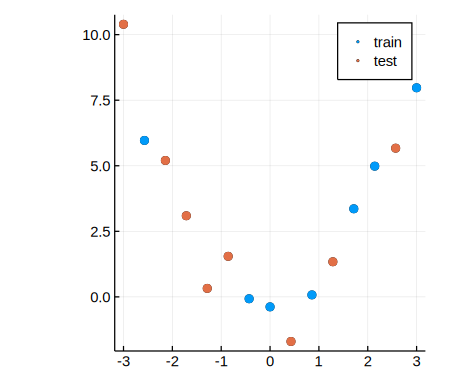

In [177]:
Random.seed!(7)

n = 15
x = range(-3,stop=3,length=n)
y = x .^ 2 + rand(Normal(),n)

(xtrain,xvalid,ytrain,yvalid) = train_test_split(x,y,at=0.47)

scatter(xtrain,ytrain,
    markersize=20,
    label="train",
    size=(1800,1500),
    legend=:topright,
    thickness_scaling=5,
    left_margin=-45px,
    bottom_margin=-45px
)
plot!(xvalid,yvalid,
    markersize=20,
    seriestype=:scatter,
    label="test"
)

p  |  train err   | valid err |
---+--------------+-----------+
0         66.9          100.5
1         61.8          129.1
2          1.5           12.9
3          0.9           12.3
4          0.1           33.9


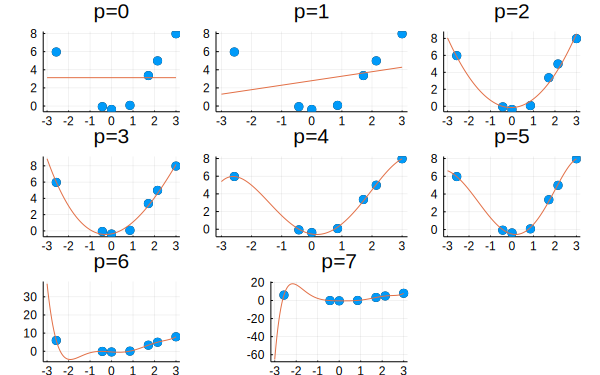

5          0.1           21.4
6          0.0          860.2
7          0.0         6021.2



In [227]:
# You do not have to read this code. But, check out the one line marked below. 

Xtrain = reshape(xtrain,length(xtrain),1)
Xvalid = reshape(xvalid,length(xvalid),1)

grid = reshape(range(minimum(x),stop=maximum(x),length=1000),1000,1)

Printf.@printf("p  |  train err   | valid err |\n")
Printf.@printf("---+--------------+-----------+\n")
plts = Array{Any}(undef,8)
for p in 0:7
    pf = initializePolynomialFeatures(X,degree=p,interaction_only=false)
    pf = pf.fit(pf,Xtrain)
    Z = pf.transform(pf,Xtrain)
    v = (Z' * Z) \ (Z' * ytrain) # solve normal equations <--- HEY, LOOK, THIS IS THE SAME!!!!! 
    grid_poly = pf.transform(pf,grid)
    
    plt1 = scatter(xtrain,ytrain,
        markersize=20,
        label="train",
        title="p=$p"
    )
#     plot!(xvalid,yvalid,
#         seriestype=:scatter,
#         markersize=20,
#         label="test"
#     )
    plot!(grid, grid_poly*v)
    plts[p+1] = plt1
    train_pred = Z*v
    train_err = sum((ytrain-train_pred) .^ 2)
    valid_pred = pf.transform(pf,Xvalid)*v
    valid_err = sum((yvalid-valid_pred) .^ 2)
    Printf.@printf("%d %12.1f   %12.1f\n",p,train_err,valid_err)
end
println()
# Printf.@printf("%d\n",maximum(broadcast(abs,v)))
# Printf.@printf("%s",v)
display(plot(plts[1],plts[2],plts[3],plts[4],plts[5],plts[6],plts[7],plts[8],
    thickness_scaling=4,
    size=(2400,1500),
    legend=false,
    left_margin=-30px,
    bottom_margin=-30px,
))

In this case, based on the validation error, a degree of 2 or 3 seems appropriate. Which is comforting, since we generated the data from a quadratic function ($p=2$). 

Foreshadowing question: can we penalize higher $p$ so that we'd definitely choose $p=2$ here? 

## (bonus "slide") The basis function view

Our predictions are $y=Zv$. (We use the notation $v$ instead of $w$ when we've transformed our features into a new space.) Consider the column view of matrix multiplication:

$$ y_i = Zv= v_1 z_{i1} + v_2 z_{i2} + \ldots + v_d z_{id}$$

Now each $z^j$ is some function of the original $x$. For example, it might be different degree polynomials. So we can rewrite this as

$$ y_i = v_1 h_1(x_i) + v_2 h_2(x_i) + \ldots + v_d h_d(x_i)$$

where the $h_j$ are these different functions. These are called _basis functions_. We're not actually using the function as a continuous entity. Instead, we're evaluating it at the trainig points for training, and evaluating it at the test points for testing. 

## Beyond polynomials

We can have all sorts of features ("basis functions"), e.g. periodic functions. 

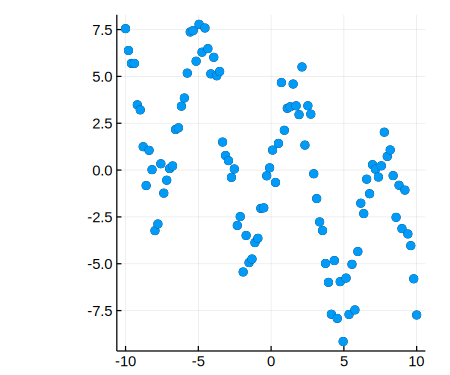

In [232]:
n = 100
x = range(-10,stop=10,length=n)
y = -x ./ 2 + 5 .* broadcast(sin,x) + rand(Normal(),n)

scatter(x,y,
    markersize=20,
    size=(1800,1500),
    thickness_scaling=5,
    legend=false,
    left_margin=-45px,
    bottom_margin=-45px
)


In [235]:
X = reshape(x,length(x),1)
Z = hcat(ones(n,1), X, broadcast(sin,X), broadcast(cos,X))
Z[1:10,:]

10×4 Array{Float64,2}:
 1.0  -10.0       0.544021   -0.839072
 1.0   -9.79798   0.364599   -0.931165
 1.0   -9.59596   0.170347   -0.985384
 1.0   -9.39394  -0.0308337  -0.999525
 1.0   -9.19192  -0.23076    -0.973011
 1.0   -8.9899   -0.421301   -0.906921
 1.0   -8.78788  -0.594705   -0.803944
 1.0   -8.58586  -0.743921   -0.668267
 1.0   -8.38384  -0.862879   -0.50541 
 1.0   -8.18182  -0.946741   -0.321996

In [236]:
v = Z' * Z \ Z' * y

4-element Array{Float64,1}:
  0.03318459818193688
 -0.47558441944093416
  4.971773549743816  
 -0.1658469247614408 

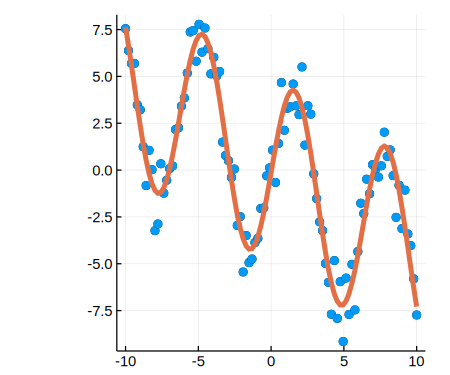

In [241]:
scatter(x,y,
    size=(1800,1500),
    markersize=20,
    thickness_scaling=5,
    left_margin=-45px,
    bottom_margin=-45px,
    legend=false
)
plot!(X,Z*v,linewidth=4)

Also, let's check out the weights!

In [242]:
v

4-element Array{Float64,1}:
  0.03318459818193688
 -0.47558441944093416
  4.971773549743816  
 -0.1658469247614408 

The "true" weights (used to generate the data) are $[0, -0.5, 5, 0]$. We did a reasonable job of "recovering" them. And all using linear regression. (We could have used scikit-learn's `LinearRegression` if we wanted to.)